# Converts the JHU Cumulative Case Count Data to Daily Case Count Data

# TO DO:
- [ ] Research random effects models in time to event studies 
- [ ] **The long versions of the death and case datasets have 55,100 rows, but the final data frame has 66,797. Need to understand why and correct, if this is no appropriate**
- [ ] **Need to run PCA to justify the method of making SDI**




## Completed
- [X] Create the social distancing metric for the cumulative incidence data set Calculated as the total number of days with social distancing implemented (either before peak transmission or X # of days after peak transmission (what is the longest recorded in the data set???)* the ordinal value of the social distancing measure, scaled so that the highest recorded value is 100.
- [X] Calculate the daily case per 100k population
- [X] Calculate the daily death per 100k population
- [X] Create the data set that will have the cumulative incidence
- [X] **BUT READ** [**THIS ARTICLE**](https://doi.org/10.1101/2020.07.04.20145334) first. It might give you ideas for how to calculate the control measures vars.
- [X] Merge in population density data
- [X] Lag the rolling mean case & death counts to the serial interval for COVID
- [X] Create a data set that will be used for the time to event study. Day 1 for all countries will be the date of their 1st reported case.
- [X] There seems to be a problem with the rolling mean calculations. It seems like they are calculated backwards. Probably an issue with the sort before they were created. Make sure they are sorted by country, date
- [X] Figure out how to fix the control measure obs that are recorded as '.'
- [X] Need to explore the missingness of the Oxford data. Sort the countries by GDP and examine what the missingness matrix looks like. **If you could run imputation on this data then you would have a major leg up on the other paper working on the similar topic. (on to of the other benefits to your paper)**
- [X] Write the code that merges in the time series data for the diffent control measures
- [X] Write the code merges in the Country Safety Index data
- [X] Continue to update this **[file](https://1drv.ms/x/s!AjWX5HOdYY23kf9x5S7g8LKLGlseVg?e=992nsi)** of data source locations 
- [X] Write the code that lets you convert the US data to long
- [X] Write the code that converts the column names in the Oxford data set to match the column names in the JHU dat
- [X] Write the code that merges the countries to their offical alpha 3 code in the JHU: **[Link to Codes](https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes)**
- [X] **ALTERNATIVE TO ABOVE** use python-Levenshtein [Docs](https://rawgit.com/ztane/python-Levenshtein/master/docs/Levenshtein.html) distance to match similar country names 
> would still need to pair the high probability matches 
- [X] Write the code transposes the combined data with the control measures included

In [1]:
import pandas as pd
import os
import sys
import shutil
import re
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] =15 ,9
import seaborn as sns
from matplotlib.pyplot import figure


In [3]:
def Correcting_Col_Names(infile_path, dset):
    infile = pd.read_csv(infile_path)
    # og_col_list = infile.columns.to_list()
    df = pd.DataFrame(infile.columns.to_list())
    df['col'] = df[2:].apply(lambda x: pd.to_datetime(x).dt.strftime('X%m/X%d/%Y').str.replace('X0','').str.replace('X',''))
    df['col'][0] = 'country'
    df['col'][1] = 'country_code'
    cols = df.col.to_list()
    control = pd.read_csv(infile_path, names = cols, skiprows={0:1})
    indexNames = control[ control['country_code'].isna()].index
    control.drop(indexNames, inplace=True)
    df = controls_transpose(control, dset)
    return df

In [4]:
def controls_transpose(dset, var):
    import re
    df = dset.T
    df.columns = df.iloc[0]
    df.columns =df.columns.str.lower()
    df.drop(axis=0, index = {'country', 'country_code'},inplace = True)
    df = df.reset_index().rename(columns={'index':'date'})
    df = long_maker(df, var)
    df.loc[df['country'].str.contains('cape verde',flags= re.IGNORECASE), 'country']= 'cabo verde'
    df.loc[df['country'].str.contains('taiwan',flags= re.IGNORECASE), 'country']= 'taiwan'
    return df

In [5]:
def df_merger(df):
    global long_df
    long_df = long_df.merge(df, on=['date', 'country'],how='outer')
    return long_df

In [6]:
def our_world_importer(filename,sheet, year=2017):
    df = pd.read_excel(f'{control_data_path}\\{filename}.xlsx', sheet_name = sheet)
    df = stats_col_renamer(df)
    df = df.loc[df.year == year]
    df.drop(columns=['entity','year'],inplace=True)
    df.dropna(how='any',inplace=True)
    return df

In [7]:
def long_maker(dset, var):
    name_list = dset.columns.to_list()[1:]
    long_df = pd.DataFrame(columns = {'date', var, 'country'})
    for name in name_list:
        df = dset.filter(items={name, 'date'})
        df['country'] = name
        df.rename(columns={name:var},inplace = True)
        long_df = pd.concat([long_df, df],axis=0)
    long_df.date = pd.to_datetime(long_df.date)
    return long_df.reset_index(drop=True)

In [8]:
def peak_date_cleaner(df, peak_id, peak_date, date_offset=1):
    """ Removes the countries with multiple peak dates from the data set
    
    """
    df_multi_peak_country = df.loc[(df[peak_id] == 1)].groupby('country')[peak_date].nunique().to_frame()
    two_peaks_country = df_multi_peak_country.loc[df_multi_peak_country[peak_date] ==2].index
    date_ranges = pd.DataFrame(df.loc[(df[peak_id] == 1)].groupby('country')[peak_date].max() - df.loc[(df[peak_id] == 1)].groupby('country')[peak_date].min()) 
    date_ranges.rename(columns={peak_date:'peak_range'},inplace =True)
    date_ranges.reset_index(inplace=True)
    df = df.merge(date_ranges,on='country',how='outer')
    df.loc[df.peak_range > pd.to_timedelta('1 day'), f'{peak_date}'] = (finaldf.date.dt.date.max() + pd.DateOffset(days=date_offset))
    df.sort_values(by = f'{peak_date}',inplace=True)
    df['dup'] = df.duplicated('country',keep='first')
    df = df.loc[~df.dup]
    df = df.drop(columns=['dup', 'peak_range'])
    return df,  date_offset

In [9]:
def stats_col_renamer(dframe):
    """
    Tips: This fuction will remove special characters from column headers, replace spaces with columns, 
    and make all heading lower case

    Parameters
    ----------
    dframe : TYPE Pandas dataframe
        DESCRIPTION.

    Returns
    -------
    None.

    """
    
    dframe.columns = dframe.columns.str.lower()
    dframe.columns = dframe.columns.str.replace('\s{2,}',' ',regex=True).str.replace('-',' ').str.replace(' ','_').str.replace('[^A-Za-z0-9_]+','',regex=True)
    return dframe
data_path = r'..\csse_covid_19_data\csse_covid_19_time_series'
out_data_path = r'..\Modified Data Sets'
control_data_path = '..\Control Data'
case_pre = pd.read_csv(f'{data_path}/time_series_covid19_confirmed_global.csv')
death_pre = pd.read_csv(f'{data_path}/time_series_covid19_deaths_global.csv')

## Importing the JHU COVID Case Data

In [10]:
# case_pre_us = pd.read_csv(f'{data_path}/time_series_covid19_confirmed_US.csv')
# death_pre_us = pd.read_csv(f'{data_path}/time_series_covid19_deaths_US.csv')


file_list = os.listdir(out_data_path)
for files in file_list:
    if files.find('.xlsx') >= 0:
        shutil.move(f'{out_data_path}/{files}',f'{out_data_path}/ARCHIVE/{files}')
def DF_Transform(df, outcome):
    global data_path
    global out_data_path
    
    # Data Cleaning
    df.drop(labels={'Lat','Long'},axis=1, inplace = True)
#     df.loc[df['Country/Region'].str.contains('Congo'), 'Country/Region'] ='Congo'
    df.loc[df['Country/Region'].str.contains('Korea, South',flags= re.IGNORECASE), 'Country/Region']= 'South Korea'
    df.loc[df['Country/Region'] == ('US'), 'Country/Region']= 'United States'
    df.loc[df['Country/Region'].str.contains('taiwan',flags= re.IGNORECASE), 'Country/Region']= 'taiwan'
    # Data Manipulation
    df = df.groupby(by='Country/Region').sum().T.apply(lambda x: x-x.shift(1),axis=0)
    df.rename(columns={'Country/Region':'Date'},inplace=True)
    df.columns = df.columns.str.lower()
    df = df.reset_index()
    df.rename(columns={'index':'date'},inplace= True)
    df.date = pd.to_datetime(df.date).dt.date
#     df['var'] = outcome[16:]
    
    filename = f'{out_data_path}/{outcome} (Through {df.date.max()}).xlsx'
    df.to_excel(filename, index=False)
    return df
case = DF_Transform(case_pre, 'Global COVID-19 Case Count')
death = DF_Transform(death_pre, 'Global COVID-19 Death Count')
# case = DF_Transform(case_pre_us, 'US COVID-19 Case Count')
# death = DF_Transform(death_pre_us, 'US COVID-19 Death Count')

In [11]:
long_case = long_maker(case, 'case_count')
long_death = long_maker(death, 'death_count')

In [12]:
case_lag_d = case.set_index('date')
case_lag1 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-1),axis=0).reset_index()
case_lag2 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-2),axis=0).reset_index()
case_lag3 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-3),axis=0).reset_index()
case_lag4 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-4),axis=0).reset_index()
case_lag5 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-5),axis=0).reset_index()
case_lag6 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-6),axis=0).reset_index()
case_lag7 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-7),axis=0).reset_index()
case_lag8 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-8),axis=0).reset_index()
case_lag9 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-9),axis=0).reset_index()
case_lag10 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-10),axis=0).reset_index()
case_lag11 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-11),axis=0).reset_index()
case_lag12 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-12),axis=0).reset_index()
case_lag13 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-13),axis=0).reset_index()
case_lag14 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-14),axis=0).reset_index()
case_lag15 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-15),axis=0).reset_index()
case_lag16 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-16),axis=0).reset_index()
case_lag17 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-17),axis=0).reset_index()
case_lag18 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-18),axis=0).reset_index()
case_lag19 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-19),axis=0).reset_index()
case_lag20 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-20),axis=0).reset_index()
case_lag21 = case_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-21),axis=0).reset_index()

death_lag_d = death.set_index('date')
death_lag1 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-1),axis=0).reset_index()
death_lag2 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-2),axis=0).reset_index()
death_lag3 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-3),axis=0).reset_index()
death_lag4 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-4),axis=0).reset_index()
death_lag5 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-5),axis=0).reset_index()
death_lag6 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-6),axis=0).reset_index()
death_lag7 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-7),axis=0).reset_index()
death_lag8 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-8),axis=0).reset_index()
death_lag9 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-9),axis=0).reset_index()
death_lag10 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-10),axis=0).reset_index()
death_lag11 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-11),axis=0).reset_index()
death_lag12 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-12),axis=0).reset_index()
death_lag13 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-13),axis=0).reset_index()
death_lag14 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-14),axis=0).reset_index()
death_lag15 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-15),axis=0).reset_index()
death_lag16 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-16),axis=0).reset_index()
death_lag17 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-17),axis=0).reset_index()
death_lag18 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-18),axis=0).reset_index()
death_lag19 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-19),axis=0).reset_index()
death_lag20 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-20),axis=0).reset_index()
death_lag21 = death_lag_d.iloc[0:,1:].apply(lambda x: x.shift(-21),axis=0).reset_index()

In [13]:
long_1 = long_maker(case_lag1,'case1')
long_2 = long_maker(case_lag2,'case2')
long_3 = long_maker(case_lag3,'case3')
long_4 = long_maker(case_lag4,'case4')
long_5 = long_maker(case_lag5,'case5')
long_6 = long_maker(case_lag6,'case6')
long_7 = long_maker(case_lag7,'case7')
long_8 = long_maker(case_lag8,'case8')
long_9 = long_maker(case_lag9,'case9')
long_10 = long_maker(case_lag10,'case10')
long_11 = long_maker(case_lag11,'case11')
long_12 = long_maker(case_lag12,'case12')
long_13 = long_maker(case_lag13,'case13')
long_14 = long_maker(case_lag14,'case14')
long_15 = long_maker(case_lag15,'case15')
long_16 = long_maker(case_lag16,'case16')
long_17 = long_maker(case_lag17,'case17')
long_18 = long_maker(case_lag18,'case18')
long_19 = long_maker(case_lag19,'case19')
long_20 = long_maker(case_lag20,'case20')
long_21 = long_maker(case_lag21,'case21')   

In [14]:
death_long_1 = long_maker(death_lag1,'death1')
death_long_2 = long_maker(death_lag2,'death2')
death_long_3 = long_maker(death_lag3,'death3')
death_long_4 = long_maker(death_lag4,'death4')
death_long_5 = long_maker(death_lag5,'death5')
death_long_6 = long_maker(death_lag6,'death6')
death_long_7 = long_maker(death_lag7,'death7')
death_long_8 = long_maker(death_lag8,'death8')
death_long_9 = long_maker(death_lag9,'death9')
death_long_10 = long_maker(death_lag10,'death10')
death_long_11 = long_maker(death_lag11,'death11')
death_long_12 = long_maker(death_lag12,'death12')
death_long_13 = long_maker(death_lag13,'death13')
death_long_14 = long_maker(death_lag14,'death14')
death_long_15 = long_maker(death_lag15,'death15')
death_long_16 = long_maker(death_lag16,'death16')
death_long_17 = long_maker(death_lag17,'death17')
death_long_18 = long_maker(death_lag18,'death18')
death_long_19 = long_maker(death_lag19,'death19')
death_long_20 = long_maker(death_lag20,'death20')
death_long_21 = long_maker(death_lag21,'death21')

## Importing the Oxford Control Variables

In [16]:
c_measures_path = r'../../../covid-policy-tracker/data'
school = Correcting_Col_Names(f'{c_measures_path}/timeseries/c1_school_closing.csv', 'school_close')
work = Correcting_Col_Names(f'{c_measures_path}/timeseries/c2_workplace_closing.csv', 'work_close')
pub_events = Correcting_Col_Names(f'{c_measures_path}/timeseries/c3_cancel_public_events.csv', 'public_events')
gatherings = Correcting_Col_Names(f'{c_measures_path}/timeseries/c4_restrictions_on_gatherings.csv', 'large_gather')
pub_transpo = Correcting_Col_Names(f'{c_measures_path}/timeseries/c5_close_public_transport.csv', 'public_transpo')
stay_home = Correcting_Col_Names(f'{c_measures_path}/timeseries/c6_stay_at_home_requirements.csv' ,'stay_home')
domestic_travel = Correcting_Col_Names(f'{c_measures_path}/timeseries/c7_movementrestrictions.csv' ,'domestic_travel')
int_travel = Correcting_Col_Names(f'{c_measures_path}/timeseries/c8_internationaltravel.csv' ,'internat_travel')

ParserError: Unknown string format: country_name

In [ ]:
#Old merge statment
long_df = long_case.merge(long_death, on=['date', 'country'])
long_df = df_merger(school)
long_df = df_merger(work)
long_df = df_merger(pub_events)
long_df = df_merger(gatherings)
long_df = df_merger(pub_transpo)
long_df = df_merger(stay_home)
long_df = df_merger(domestic_travel)
long_df = df_merger(int_travel)
#Merging Long Case DFs
long_df = df_merger(long_1)
long_df = df_merger(long_2)
long_df = df_merger(long_3)
long_df = df_merger(long_4)
long_df = df_merger(long_5)
long_df = df_merger(long_6)
long_df = df_merger(long_7)
long_df = df_merger(long_8)
long_df = df_merger(long_9)
long_df = df_merger(long_10)
long_df = df_merger(long_11)
long_df = df_merger(long_12)
long_df = df_merger(long_13)
long_df = df_merger(long_14)
long_df = df_merger(long_15)
long_df = df_merger(long_16)
long_df = df_merger(long_17)
long_df = df_merger(long_18)
long_df = df_merger(long_19)
long_df = df_merger(long_20)
long_df = df_merger(long_21)
#Merging the long death vars
long_df = df_merger(death_long_1)
long_df = df_merger(death_long_2)
long_df = df_merger(death_long_3)
long_df = df_merger(death_long_4)
long_df = df_merger(death_long_5)
long_df = df_merger(death_long_6)
long_df = df_merger(death_long_7)
long_df = df_merger(death_long_8)
long_df = df_merger(death_long_9)
long_df = df_merger(death_long_10)
long_df = df_merger(death_long_11)
long_df = df_merger(death_long_12)
long_df = df_merger(death_long_13)
long_df = df_merger(death_long_14)
long_df = df_merger(death_long_15)
long_df = df_merger(death_long_16)
long_df = df_merger(death_long_17)
long_df = df_merger(death_long_18)
long_df = df_merger(death_long_19)
long_df = df_merger(death_long_20)
long_df = df_merger(death_long_21)

In [ ]:
df_long_list = [case_lag1,case_lag2,case_lag3,case_lag4,case_lag5,case_lag6,
                case_lag7,case_lag8,case_lag9,case_lag10,case_lag11,case_lag12,
                case_lag13,case_lag14,case_lag15,case_lag16,case_lag17,case_lag18,
                case_lag19,case_lag20,case_lag21,death_lag1,death_lag2,death_lag3,
                death_lag4,death_lag5,death_lag6,death_lag7,death_lag8,death_lag9,
                death_lag10,death_lag11,death_lag12,death_lag13,death_lag14,
                death_lag15,death_lag16,death_lag17,death_lag18,death_lag19,death_lag20,
                death_lag21,death_long_1,death_long_2,death_long_3,death_long_4,death_long_5,
               death_long_6,death_long_7,death_long_8,death_long_9,death_long_10,death_long_11,
                death_long_12,death_long_13,death_long_14,death_long_15,death_long_16,death_long_17,
                death_long_18,death_long_19,death_long_20,death_long_21,long_1,long_2,long_3,long_4,
                long_5,long_6,long_7,long_8,long_9,long_10,long_11,long_12,long_13,long_14,
                long_15,long_16,long_17,long_18,long_19,long_20,long_21]
for dfs in df_long_list:
    del dfs

In [ ]:

long_df[['school_close',
       'work_close', 'public_events', 'large_gather', 'public_transpo',
       'stay_home', 'domestic_travel', 'internat_travel']] = long_df[['school_close',
       'work_close', 'public_events', 'large_gather', 'public_transpo',
       'stay_home', 'domestic_travel', 'internat_travel']].apply(lambda x: x.replace('.',np.nan))
long_df[['school_close',
       'work_close', 'public_events', 'large_gather', 'public_transpo',
       'stay_home', 'domestic_travel', 'internat_travel']] = long_df[['school_close',
       'work_close', 'public_events', 'large_gather', 'public_transpo',
       'stay_home', 'domestic_travel', 'internat_travel']].fillna(np.nan)
control_list = ['school_close','work_close', 'public_events', 'large_gather', 'public_transpo', 'stay_home', 'domestic_travel', 'internat_travel']
for measure in control_list:
    long_df[measure] = pd.to_numeric(long_df[measure])

In [ ]:
case_summary = long_df.groupby('country').case_count.agg(['mean','median','std', 'max'])
death_summary = long_df.groupby('country').case_count.agg(['mean','median','std', 'max'])

In [ ]:
long_df[['school_close',
       'work_close', 'public_events', 'large_gather', 'public_transpo',
       'stay_home', 'domestic_travel', 'internat_travel']].info()

# Importing Control Variables

In [ ]:
control_var_path = '../Control Data'

In [ ]:
def country_name_clean(df):
    import re
#     df.loc[(df['country'].str.contains('Congo',re.IGNORECASE)) & (~df['country'].str.contains('dem',re.IGNORECASE)) , 'country'] ='congo'
    df.loc[(df['country'].str.contains('korea, s',flags= re.IGNORECASE)) & (df['country'].str.contains('south',flags= re.IGNORECASE)), 'country']= 'south korea'
    df.loc[df['country'].str.contains('rep')& (df['country'].str.contains('congo',flags= re.IGNORECASE)) ,'country']= 'democratic republic of congo'
    df.loc[df['country'] == ('US'), 'country']= 'united states'
    df.loc[df['country'].str.contains('ivoire|ivory coast',flags= re.IGNORECASE), 'country']= 'cote d\'ivoire'
    df.loc[df['country'].str.contains('venezuela',flags= re.IGNORECASE), 'country']= 'venezuela'
    df.loc[df['country'].str.contains('and principe',flags= re.IGNORECASE), 'country']= 'sao tome and principe'
    df.loc[df['country'].str.contains('and the grenadines',flags= re.IGNORECASE), 'country']= 'saint vincent and the grenadines'
    df.loc[df['country'].str.contains('kitts and nevis',flags= re.IGNORECASE), 'country']= 'saint kitts and nevis'
    df.loc[df['country'].str.contains('bahamas',flags= re.IGNORECASE), 'country']= 'bahamas'
    df.loc[df['country'].str.contains('yemen',flags= re.IGNORECASE), 'country']= 'yemen'
    df.loc[df['country'].str.contains('gambia',flags= re.IGNORECASE), 'country']= 'gambia'
    df.loc[df['country'].str.contains('hong kong',flags= re.IGNORECASE), 'country']= 'hong kong'
    df.loc[df['country'].str.contains('macao',flags= re.IGNORECASE), 'country']= 'macao'
    df.loc[df['country'].str.contains('iran',flags= re.IGNORECASE), 'country']= 'iran'
    df.loc[df['country'].str.contains('lucia',flags= re.IGNORECASE), 'country']= 'saint lucia'
    df.loc[df['country'].str.contains('lao pdr',flags= re.IGNORECASE), 'country']= 'laos'
    df.loc[df['country'].str.contains('egypt',flags= re.IGNORECASE), 'country']= 'egypt'
    df.loc[df['country'].str.contains('korea, rep.',flags= re.IGNORECASE), 'country']= 'south korea'
    df.loc[df['country'].str.contains('states of america',flags= re.IGNORECASE), 'country']= 'united states'
    df.loc[df['country'].str.contains('east timor',flags= re.IGNORECASE), 'country']= 'timor-leste'
    df.loc[df['country'].str.contains('russia',flags= re.IGNORECASE), 'country']= 'russia'
    df.loc[df['country'].str.contains('brunei',flags= re.IGNORECASE), 'country']= 'brunei'
    df.loc[df['country'].str.contains('korea, dem. people\'s rep',flags= re.IGNORECASE), 'country']= 'north korea'
    dset = df.copy()
    return dset


In [ ]:
#COVID Regional Safety Assessment Data
safety = pd.read_excel(f'{control_var_path}/COVID-19_Regional_Safety_Assessment.xlsx')
safety.columns = safety.columns.str.lower()
safety.rename(columns={'country/ region':'country'}, inplace=True)
safety.country = safety.country.str.lower()
safety = country_name_clean(safety)

#World Bank GDP Data
gdp = pd.read_excel(f'{control_var_path}/Global GDP.xlsx')
gdp.drop(columns='Unnamed: 4', inplace=True)
gdp.columns = gdp.columns.str.lower()
gdp.rename(columns={'economy':'country'}, inplace=True)
gdp.country = gdp.country.str.lower()

og_data = pd.read_excel('..\..\Country Response Paper\Original Documents\Country Responses-selected\Country Responses Dataset 7.28.20.xlsx',sheet_name = 'Country Responses')
og_data.index = og_data['Country/Region']
og_data = og_data.iloc[0:,19:]
og_data = og_data.reset_index(drop=False).rename(columns={'Country/Region':'country'})
og_data.columns = og_data.columns.str.lower()
og_data = stats_col_renamer(og_data)
og_data.dropna(how='all',inplace=True)
og_data.country = og_data.country.str.lower()

safety = country_name_clean(safety)
gdp = country_name_clean(gdp)
og_data = country_name_clean(og_data)

# Importing and evaluating the smoking dataset from Our World Data

In [ ]:
#Smoking Data
smk_die_rate = our_world_importer('share-deaths-smoking', 'death-rate-smoking')
smk_die_prop = our_world_importer('share-deaths-smoking', 'share-deaths-smoking')

#HIV Data
hiv_prev = our_world_importer('hiv-data','share-of-population-infected-wi')
hiv_death = our_world_importer('hiv-data','hiv-death-rates')
#Obesity Data
obese = our_world_importer('share-of-deaths-obesity','share-of-deaths-obesity')

#Population Data
pop = our_world_importer('projected-population-by-country', 'projected-population-by-country',year=2020)
pop_den = our_world_importer('population-density','population-density', year=2017)
pop_den.rename(columns={'population_density_people_per_sq_km_of_land_area':'pop_den_per_sqkm'},inplace=True)

#Age Data
age = our_world_importer('median-age','median-age',year=2020)

#Diabetes Data
diabet = our_world_importer('diabetes-prevalence', 'diabetes-prevalence')
mers = pd.read_excel(f'{control_data_path}\MERS-SARS.xlsx',sheet_name='MERS')
sars = pd.read_excel(f'{control_data_path}\MERS-SARS.xlsx',sheet_name='SARS')
mers = stats_col_renamer(mers)
sars = stats_col_renamer(sars)
sars.drop(columns=['number_of_hcw_affected_', 'date_onset_first_probable_case',
       'date_onset_last_probable_case','case_fatality_ratio_','female', 'male','areas','median_age_range'],inplace=True)
mers.drop(columns='country',inplace=True)

In [ ]:
def mers_sars_quat_make(df):
    df[['mers_case_count',
       'sars_case_count', 'number_of_deathsa', 'number_of_imported_cases',
       'percent_of_imported_cases']] = df[['mers_case_count',
       'sars_case_count', 'number_of_deathsa', 'number_of_imported_cases',
       'percent_of_imported_cases']].fillna(0)
    df['mers_sars_max'] = df[['mers_case_count', 'sars_case_count']].max(axis=1)
    df['mers_sars_sum'] = df[['mers_case_count', 'sars_case_count']].sum(axis=1)
    df['mers_sars_quart'] = 0
    mers_sars_sum =  control.loc[control.mers_sars_sum > 0 ]['mers_sars_sum']
    des_mers_sum = mers_sars_sum.describe().to_frame()
    q1 = int(des_mers_sum.iloc[4].values)
    q2 = int(des_mers_sum.iloc[5].values)
    q3 = int(des_mers_sum.iloc[6].values)
    df.loc[(df.mers_sars_sum > 0) & (df.mers_sars_sum <= q1), 'mers_sars_quart']=1
    df.loc[(df.mers_sars_sum > q1) & (df.mers_sars_sum <= q2), 'mers_sars_quart']=2
    df.loc[(df.mers_sars_sum > q2) & (df.mers_sars_sum <= q3), 'mers_sars_quart']=3
    df.loc[df.mers_sars_sum > q3, 'mers_sars_quart']=4
    return df

### How to Merge a lot of DataFrames
> Method 1

In [ ]:
from functools import partial, reduce

In [ ]:
dfs = [smk_die_rate, smk_die_prop,hiv_prev, hiv_death, obese, pop, pop_den, age, diabet, mers, sars]
merge = partial(pd.merge,on='code', how='outer')
control = reduce(merge,dfs)
#creating the quartile variable
control = mers_sars_quat_make(control)


> Method 2

In [ ]:
# control = smk_die_rate.copy()
# control = control.merge(smk_die_prop, on='code', how='outer')
# control = control.merge(hiv_prev, on='code', how='outer')
# control = control.merge(hiv_death, on='code', how='outer')
# control = control.merge(obese, on='code', how='outer')
# control = control.merge(pop, on='code', how='outer')
# control = control.merge(age, on='code', how='outer')
# control = control.merge(diabet, on='code', how='outer')
# control = control.merge(mers, on='code', how='outer')
# control = control.merge(sars, on='code', how='outer')

# Final Merges

In [ ]:
long_df_newcontrol = control.merge(gdp,left_on='code',right_on='countrycode',how='outer')
long_df_newcontrol = long_df_newcontrol.merge(long_df, on=['country'],how='outer')
long_df_newcontrol = long_df_newcontrol.merge(safety, on=['country'],how='outer')
long_df_newcontrol = long_df_newcontrol.merge(og_data, on=['country'],how='outer')
long_df_newcontrol.rename(columns={'us_dollars_in_mil':'gdp_in_mil_us', 'ranking':'gdp_rank'},inplace=True)
long_df_newcontrol = stats_col_renamer(long_df_newcontrol)
long_df_newcontrol.drop(columns={'global_region','code'},inplace=True)
long_df_newcontrol.columns = long_df_newcontrol.columns.str.replace('__','_')
long_df_newcontrol.countrycode = long_df_newcontrol.countrycode.str.upper()
long_df_order = ['date',  'country','case_count', 'death_count', 'school_close',
       'work_close', 'public_events', 'large_gather', 'public_transpo',
       'stay_home', 'domestic_travel', 'internat_travel', 'population','pop_den_per_sqkm',
       'ages_65_and_above_of_total_population', 'female_of_total',
       'diabetes_prevalence_of_population_ages_20_to_79',
       'obese_of_adult_population', 'htn_prevalence',
       'smoking_prevalence_ages_15', 'cancer_prevalence_',
       'hiv_prevalence_of_population_ages_1549', 'copd_dalys_per_100000',
       'sars_experience_0_no_1_yes', 'quarantine_efficiency', 'gov_efficiency',
       'monitoring_and_detection', 'healthcare_readiness',
       'country_vulnerability', 'emergency_preparedness', 'total_score',
       'countrycode', 'gdp_rank', 'gdp_in_mil_us']
long_df_newcontrol = long_df_newcontrol.filter(items=['country','countrycode','date','case_count','death_count',
'school_close', 'domestic_travel','internat_travel','large_gather', 'public_events',
'stay_home', 'work_close' ,'public_transpo',
'gdp_rank', 'us_dollars_in_mil','smoking_ihme_2019', 'population_by_country_and_region_historic_and_projections_gapminder_hyde_un','pop_den_per_sqkm',
'un_population_division_median_age_2017','ages_65_and_above_of_total_population',
'prevalence_hivaids_sex_both_age_15_49_years_percent',
'deaths_hivaids_sex_both_age_age_standardized_rate', 
'diabetes_prevalence_of_population_ages_20_to_79_x',
'deaths_smoking_sex_both_age_age_standardized_rate','cancer_prevalence_',
'htn_prevalence', 'copd_dalys_per_100000', 'obesity_ihme_2019',
'country_vulnerability','emergency_preparedness','gov_efficiency','healthcare readiness',
'monitoring and detection', 'quarantine_efficiency', 'total_score',
'mers_case_count', 'sars_case_count', 'mers_sars_sum','mers_sars_quart','mers_sars_max' , 
'number_of_deathsa', 'number_of_imported_cases', 'percent_of_imported_cases',
'case1', 'case2', 'case3', 'case4', 'case5', 'case6', 'case7', 'case8',
'case9', 'case10', 'case11', 'case12', 'case13', 'case14', 'case15',
'case16', 'case17', 'case18', 'case19', 'case20', 'case21', 'death1',
'death2', 'death3', 'death4', 'death5', 'death6', 'death7', 'death8',
'death9', 'death10', 'death11', 'death12', 'death13', 'death14',
'death15', 'death16', 'death17', 'death18', 'death19', 'death20',
'death21'])
long_df_newcontrol.rename(columns={'us_dollars_in_mil':'gdp_in_mil_us', 'population_by_country_and_region_historic_and_projections_gapminder_hyde_un':'pop_2020',
                                   'deaths_hivaids_sex_both_age_age_standardized_rate':'deaths_hivaids_sex_both_age',
                                  'diabetes_prevalence_of_population_ages_20_to_79_x':'diabetes_prev_ages_20_to_79',
                                  'cancer_prevalence_':'cancer_prevalence'},inplace=True)
date = long_df_newcontrol.date.max().date()
date

Creating SARS/MERS Experience Variables

In [ ]:
long_df_newcontrol.mers_case_count = long_df_newcontrol.mers_case_count.fillna(0)
long_df_newcontrol.sars_case_count = long_df_newcontrol.sars_case_count.fillna(0)
long_df_newcontrol['mers_sars_exp1'] = 0
long_df_newcontrol['mers_sars_exp5'] = 0
long_df_newcontrol['mers_sars_exp10'] = 0
long_df_newcontrol['mers_sars_exp20'] = 0
long_df_newcontrol['mers_sars_exp100'] = 0
long_df_newcontrol['mers_sars_exp200'] = 0
long_df_newcontrol.loc[long_df_newcontrol.mers_sars_max >= 1, 'mers_sars_exp1' ] = 1
long_df_newcontrol.loc[long_df_newcontrol.mers_sars_max >= 5, 'mers_sars_exp5' ] = 1
long_df_newcontrol.loc[long_df_newcontrol.mers_sars_max >= 10, 'mers_sars_exp10' ] = 1
long_df_newcontrol.loc[long_df_newcontrol.mers_sars_max >= 20, 'mers_sars_exp20' ] = 1
long_df_newcontrol.loc[long_df_newcontrol.mers_sars_max >= 100, 'mers_sars_exp100' ] = 1
long_df_newcontrol.loc[long_df_newcontrol.mers_sars_max >= 200, 'mers_sars_exp200' ] = 1
long_df_newcontrol['log_case_count']=0
long_df_newcontrol['log_death_count']=0
long_df_newcontrol.loc[long_df_newcontrol.case_count == 0, 'log_case_count' ] = np.log(long_df_newcontrol.case_count + .5)
long_df_newcontrol.loc[long_df_newcontrol.case_count > 0, 'log_case_count' ] = np.log(long_df_newcontrol.case_count)
long_df_newcontrol.loc[long_df_newcontrol.death_count == 0, 'log_death_count' ] = np.log(long_df_newcontrol.death_count + .5)
long_df_newcontrol.loc[long_df_newcontrol.death_count > 0, 'log_death_count' ] = np.log(long_df_newcontrol.death_count)
long_df_newcontrol = long_df_newcontrol.loc[~long_df_newcontrol.date.isnull()]
long_df_newcontrol = long_df_newcontrol.sort_values(by=['country','date'])
multii = long_df_newcontrol.set_index(['country','date'])
# rolmean_case =  pd.DataFrame(multii.groupby(['country','date'])['case_count'].rolling(7).mean())
rolmean_case =  pd.DataFrame(multii.groupby(level=0,as_index=False,group_keys=False)['case_count'].rolling(7).mean()).reset_index(level=0, drop=True)
rolmean_death =  pd.DataFrame(multii.groupby(as_index=False,level=0)['death_count'].rolling(30).mean()).reset_index(level=0, drop=True)
rolmean_case['case_rol_mean_lag7'] = rolmean_case.case_count.shift(-7)
rolmean_death['death_rol_mean_lag7'] = rolmean_death.death_count.shift(-7)
rolmeans = rolmean_case.merge(rolmean_death,left_index=True,right_index=True)
rolmeans.rename(columns={'case_count':'case_rol_mean7','death_count':'death_rol_mean7'},inplace=True)
rolmeans.reset_index(inplace=True)
rolmeans['dup'] = rolmeans.duplicated()
rolmeans = rolmeans.loc[~rolmeans.dup]
rolmeans = rolmeans.drop(columns='dup')
finaldf = long_df_newcontrol.merge(rolmeans, on=['country','date'])
finaldf = long_df_newcontrol.merge(rolmeans, on=['country','date'])
finaldf['dup'] = finaldf.duplicated(['country','date','case_count','death_count','school_close'])
finaldf = finaldf.loc[finaldf.dup == False]

### Making sure that the lags worked correctly

In [ ]:
rolmean_case.groupby(level=0)['case_rol_mean_lag7'].plot(x=rolmean_case.index[1], color='black',label='Lagged Values'),rolmean_case.groupby(level=0)['case_count'].plot(x=rolmean_case.index[1],color='red',label='Non-lagged values')


In [ ]:
finaldf.set_index('date').groupby('country').case_rol_mean7.plot()

In [ ]:
finaldf.columns

In [ ]:
# finaldf.to_excel(f'{out_data_path}\\Final COVID Data Set (Through {date}) (ver2).xlsx',index=False)

**Creating a Data Set With Just Country Codes in it to Facilitate Later Merging**

In [ ]:
cc = finaldf[['country','countrycode']]
cc['dup'] = cc.duplicated('country')
cc = cc.loc[~cc.dup]
cc.drop(columns=['dup'], inplace=True)
cc.rename(columns={'countrycode':'code'}, inplace=True)

# Data Set for the Linear Model of Cumulative Incidence Rates

In [ ]:
gdp.rename(columns={'countrycode':'code'},inplace=True)

In [ ]:
# safety

In [ ]:
cum_df = pd.DataFrame(columns=['cum_case_count','cum_death_count'])
cum_df[['cum_case_count','cum_death_count']] = finaldf.groupby('country')[['case_count','death_count']].sum()
dfs = [cc,smk_die_rate, smk_die_prop,hiv_prev, hiv_death, obese, pop, pop_den, age, diabet, mers, sars]
merge = partial(pd.merge,on='code', how='outer')
control_norepeat = reduce(merge,dfs)
control_norepeat[['mers_case_count','sars_case_count']] = control_norepeat[['mers_case_count','sars_case_count']].fillna(0)
control_norepeat = mers_sars_quat_make(control_norepeat)
cum_df = cum_df.merge(control_norepeat,on='country')
cum_df.rename(columns={'population_by_country_and_region_historic_and_projections_gapminder_hyde__un':'pop_2020'},inplace=True)
cum_df['case_incid_100k'] = (cum_df.cum_case_count/cum_df.pop_2020)*100000
cum_df['death_incid_100k'] = (cum_df.cum_death_count/cum_df.pop_2020)*100000
cum_df = cum_df.merge(gdp,on=['country','code'],how='outer')
cum_df = cum_df.merge(safety, on=['country'],how='outer')
cum_df = cum_df.loc[~cum_df.cum_case_count.isnull()]
cum_df.columns

In [ ]:
cum_df

In [ ]:
finaldf.columns

# Calculating the peak transmission and death dates

In [ ]:
time_to_event = finaldf[['country','case_count','death_count',
                         'case_rol_mean7','death_rol_mean7','date',
                         'school_close', 'work_close', 'public_transpo','gdp_rank', 'gdp_in_mil_us', 
                         'domestic_travel','large_gather','public_events', 
                         'stay_home','pop_2020','pop_den_per_sqkm', 'un_population_division_median_age_2017',
                         'ages_65_and_above_of_total_population','prevalence_hivaids_sex_both_age_15_49_years_percent',
                         'deaths_hivaids_sex_both_age', 'diabetes_prev_ages_20_to_79',
                         'deaths_smoking_sex_both_age_age_standardized_rate',
                         'cancer_prevalence', 'htn_prevalence', 'copd_dalys_per_100000',
                         'obesity_ihme_2019', 'country_vulnerability', 'emergency_preparedness',
                         'gov_efficiency', 'quarantine_efficiency', 'total_score','mers_sars_quart']].copy()

#Getting the maximum value for the rolling mean for each country
max_rol_mean_c = time_to_event.groupby('country').case_rol_mean7.max().reset_index()
max_rol_mean_c.rename(columns = {'case_rol_mean7':'case_max_rol_mean7'},inplace=True)
max_rol_mean_d = time_to_event.groupby('country').death_rol_mean7.max().reset_index()
max_rol_mean_d.rename(columns = {'death_rol_mean7':'death_max_rol_mean7'},inplace=True)
time_to_event = time_to_event.merge(max_rol_mean_c, on='country')
time_to_event = time_to_event.merge(max_rol_mean_d, on='country')


#Creating the peak death and case indicators
time_to_event['peak_case'] = 0
time_to_event['peak_death'] = 0
time_to_event.loc[time_to_event.case_rol_mean7.round(3) == time_to_event['case_max_rol_mean7'].round(3), 'peak_case'] = 1 
time_to_event.loc[time_to_event.death_rol_mean7.round(3) == time_to_event['death_max_rol_mean7'].round(3), 'peak_death'] = 1


# Creating the peak case dates
peak_dates_c = time_to_event.loc[time_to_event.peak_case == 1][['country','date']]
peak_dates_c.rename(columns={'date':'case_peak_date'},inplace=True)
    # Finding and flagging countries with multiple peaks
multiple_peak_c = peak_dates_c.country.value_counts().to_frame()
multiple_peak_c = multiple_peak_c.loc[multiple_peak_c.country > 1]
muli_peak_case_countries = multiple_peak_c.index
peak_dates_c['case_muli_peak'] = 0
for country in muli_peak_case_countries:
    peak_dates_c.loc[peak_dates_c.country== country, 'case_muli_peak'] = 1
peak_dates_c, date_offset = peak_date_cleaner(peak_dates_c, 'case_muli_peak','case_peak_date')


# Creating the peak death dates
peak_dates_d = time_to_event.loc[time_to_event.peak_death == 1][['country','date']]
peak_dates_d.rename(columns={'date':'death_peak_date'},inplace=True)
    # Finding and flagging countries with multiple peaks
multiple_peak_d = peak_dates_d.country.value_counts().head(60).to_frame()
multiple_peak_d = multiple_peak_d.loc[multiple_peak_d.country > 1]
muli_peak_death_countries = multiple_peak_d.index
peak_dates_d['death_muli_peak'] = 0
for country in muli_peak_case_countries:
    peak_dates_d.loc[peak_dates_d.country== country, 'death_muli_peak'] = 1
peak_dates_d, date_offset  = peak_date_cleaner(peak_dates_d, 'death_muli_peak','death_peak_date')  


peak_dates = peak_dates_c.merge(peak_dates_d,on='country')
time_to_event = pd.merge(left=time_to_event, right=peak_dates, on='country', how='outer')


# Setting the Post Peak Period
time_to_event.loc[time_to_event.date > time_to_event.case_peak_date, 'peak_case'] = 2
time_to_event.loc[time_to_event.date > time_to_event.death_peak_date, 'peak_death'] = 2

time_to_event.loc[time_to_event.case_peak_date == finaldf.date.dt.date.max() + pd.DateOffset(days=date_offset),'peak_case'] = 0
time_to_event.loc[time_to_event.death_peak_date == finaldf.date.dt.date.max() + pd.DateOffset(days=date_offset), 'peak_death'] = 0

# Removing all case and death counts that occurred after the peak in reports 
time_to_event.loc[time_to_event.peak_case==2, 'case_count'] = np.nan
time_to_event.loc[time_to_event.peak_death==2, 'death_count'] = np.nan


#Removing all values the occured before the 1st case report
time_to_event['case_reported'] = 0
time_to_event['death_reported'] = 0
time_to_event.loc[time_to_event.case_count > 0 ,'case_reported'] = 1
time_to_event.loc[time_to_event.death_count > 0 ,'death_reported'] = 1
time_to_event['first_case_reported'] = 0
time_to_event['first_death_reported'] = 0
time_to_event['day'] =''

In [ ]:
# # Identifying the Countries with two peaks the occur in consecutive days
# for countries in two_peaks_country:
#     print(peak_dates.loc[peak_dates.country == countries ])
    

## Evaluating the Countries With Multiple Peak Values

In [ ]:
print(f'The number of countries with more than one date where the same peak value for rolling mean case count was calculated: {multiple_peak_c.shape[0]}')

In [ ]:
print(f'The number of countries with more than one date where the same peak value for rolling mean death count was calculated: {multiple_peak_d.shape[0]}')

In [ ]:
muli_peak_case_countries

In [ ]:
for countries in muli_peak_case_countries:
    sns.lineplot(y ='case_rol_mean7',x='date',data = finaldf.loc[finaldf.country ==countries],label=countries)
    plt.legend(loc='best')
plt.title('Countries With Multiple Peak Dates in the Rolling Mean Case Count')

### Low Case Count countries With More Than One Peak Case Date

In [ ]:
# case_multi_peak_country = peak_dates_c.loc[(peak_dates_c.case_muli_peak == 1)].groupby('country').case_peak_date.nunique().to_frame()
# two_peaks_country = case_multi_peak_country.loc[case_multi_peak_country.case_peak_date ==2].index
# two_peaks_country

In [ ]:
# rol_mean_limit = 100
# for countries in muli_peak_case_countries:
#     sns.lineplot(y ='case_rol_mean7',x='date',data = finaldf.loc[(finaldf.country ==countries) & (finaldf.groupby('country').case_rol_mean7.max() < rol_mean_limit)],label=countries)
#     plt.legend(loc='best')
# plt.title(f"""Countries With Multiple Peak Dates in the Rolling Mean Case Count & 
# A Rolling Mean Lower Than{rol_mean_limit}""")

In [ ]:
country = 'ecuador'
sns.lineplot(y ='case_rol_mean7',x='date' ,data = finaldf.loc[finaldf.country ==country],label='Rolling 7-Day Mean')
sns.lineplot(y ='case_count',x='date' ,data = finaldf.loc[finaldf.country ==country],label='Daily Case Count')
plt.title(f'Rolling Mean Case Count in {country[0].upper()}{country[1:]}')
plt.ylabel('Number of Cases')

In [ ]:
muli_peak_death_countries

In [ ]:
for country in time_to_event.country.unique():
    df = time_to_event.loc[time_to_event.country == country]
    date_c = df.iloc[df.case_reported.ne(0).argmax()]['date']
    date_d = df.iloc[df.death_reported.ne(0).argmax()]['date']
    time_to_event.loc[(time_to_event.country == country) & (time_to_event.date >= date_c),'first_case_reported'] = 1
    time_to_event.loc[(time_to_event.country == country) & (time_to_event.date >= date_d),'first_death_reported'] = 1
del df
time_to_event_case = time_to_event.loc[(time_to_event.first_case_reported > 0) & (time_to_event.peak_case < 2) ].reset_index()
time_to_event_case = time_to_event_case.drop(columns=['death_peak_date', 'case_reported', 'death_reported',
                                 'first_case_reported', 'first_death_reported','death_count',
                                 'death_rol_mean7','death_max_rol_mean7'])
time_to_event_death = time_to_event.loc[(time_to_event.first_death_reported > 0) & (time_to_event.peak_death < 2)].reset_index()
time_to_event_death = time_to_event_death.drop(columns=['case_count','case_rol_mean7','case_max_rol_mean7',
                                                        'case_peak_date','case_muli_peak','death_reported', 
                                                        'first_case_reported', 'first_death_reported'])
counter = 0
# Creates the day count variable
for country in time_to_event.country.unique():
    time_to_event_case.loc[time_to_event_case.country == country ,'day'] = (time_to_event_case.loc[time_to_event_case.country == country].date - (time_to_event_case.loc[time_to_event_case.country == country].date.min() + pd.DateOffset(-1)))
    time_to_event_death.loc[time_to_event_death.country == country ,'day'] = (time_to_event_death.loc[time_to_event_death.country == country].date - (time_to_event_death.loc[time_to_event_death.country == country].date.min() + pd.DateOffset(-1)))
time_to_event_case['day_num'] = time_to_event_case.day.astype('timedelta64[D]').dt.components.days
time_to_event_death['day_num'] = time_to_event_death.day.astype('timedelta64[D]').dt.components.days

# Creating the control var composite variable

In [ ]:
time_to_event_case.columns

### Calculating the number of observations per country

In [ ]:
time_to_event_case.day_num.max(), time_to_event_death.day_num.max()

In [ ]:
num_obs_country = time_to_event_case.country.value_counts().to_frame()
num_obs_country.rename(columns={'country':'n_days'},inplace=True)
num_obs_country = num_obs_country.reset_index()
num_obs_country.set_index('index',inplace=True)


In [ ]:
sns.displot(x='n_days', data=num_obs_country)
plt.title('Distribution of the Number of Obs. per Country')
plt.xlabel('Number of Observations')
plt.ylabel('Number of Countries')

In [ ]:
time_to_event_case.country.value_counts().to_frame()['country'].describe()

# After PCA If not all of the variables are needed in the composite then drop them here

In [ ]:
time_to_event_case[['school_close', 'work_close', 'public_transpo', 'domestic_travel',
       'large_gather', 'public_events', 'stay_home',]].describe()

In [ ]:
control_var_list = ['school_close','work_close','public_transpo', 'domestic_travel', 'large_gather', 'public_events','stay_home']
# control_var_list = ['school_close','work_close', 'large_gather', 'stay_home']

In [ ]:
# Creating the blank strigency index variable
def si_maker(dset):
    SI = pd.DataFrame({'country':list(dset.country.unique())})
    SI.set_index('country',inplace=True)
    for var in control_var_list:
        df = dset.groupby('country')[var].value_counts().to_frame()
        df.rename(columns={var:var+'_count'},inplace=True)
        df.reset_index(inplace=True)
        df[var+'_sum'] = df[var]*df[var+'_count']
        df = df.groupby('country')[var+'_sum'].sum().to_frame()
        df = df.merge(num_obs_country,left_index=True, right_index=True)
        df['SI_'+ var] = df[var+'_sum'] /df.n_days
        df = df.filter(['SI_'+ var])
        SI = SI.merge(df,left_index=True, right_index=True,how='outer')
        
    del df
    SI['SI_sum']= SI.iloc[0:,0:].sum(axis=1)
    SI['constant'] = 100 / SI.SI_sum.max()
    SI['sdi'] = SI['constant'] * SI['SI_sum']
    SI.reset_index(inplace=True)
    SI.rename(columns={'index':'country'},inplace=True)
    return SI

In [ ]:
si_case = si_maker(time_to_event_case)
si_death = si_maker(time_to_event_death)
si_cum = si_maker(time_to_event.loc[time_to_event.peak_case < 2][['country','date','school_close','work_close','public_transpo', 'domestic_travel', 'large_gather', 'public_events','stay_home']])

In [61]:
si_case.columns

Index(['country', 'SI_school_close', 'SI_work_close', 'SI_public_transpo',
       'SI_domestic_travel', 'SI_large_gather', 'SI_public_events',
       'SI_stay_home', 'SI_sum', 'constant', 'sdi'],
      dtype='object')

In [62]:
si_case.head(5)

,country,SI_school_close,SI_work_close,SI_public_transpo,SI_domestic_travel,SI_large_gather,SI_public_events,SI_stay_home,SI_sum,constant,sdi
0,afghanistan,2.446602,2.155340,1.359223,1.242718,2.407767,1.883495,1.417476,12.912621,5.543977,71.587271
1,albania,2.178571,1.817460,1.039683,0.634921,3.111111,1.833333,0.634921,11.250000,5.543977,62.369737
2,algeria,2.388679,1.701887,1.237736,1.041509,2.709434,1.449057,1.728302,12.256604,5.543977,67.950325
3,andorra,0.957529,1.918919,0.845560,0.000000,1.482625,1.096525,0.891892,7.193050,5.543977,39.878102
4,angola,2.766234,2.012987,1.064935,1.896104,3.549784,1.796537,1.506494,14.593074,5.543977,80.903659


Text(10.049999999999997, 0.5, 'Number of Countries')

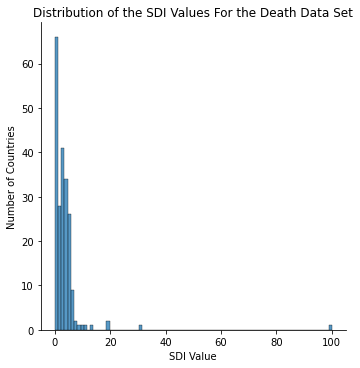

In [63]:
sns.displot(x='sdi', data=si_death)
plt.title('Distribution of the SDI Values For the Death Data Set')
plt.xlabel('SDI Value')
plt.ylabel('Number of Countries')

Text(10.049999999999997, 0.5, 'Number of Countries')

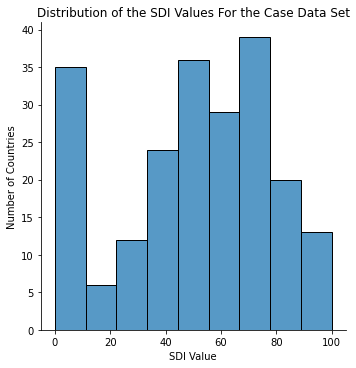

In [64]:
sns.displot(x='sdi', data=si_case)
plt.title('Distribution of the SDI Values For the Case Data Set')
plt.xlabel('SDI Value')
plt.ylabel('Number of Countries')

Text(10.049999999999997, 0.5, 'Number of Countries')

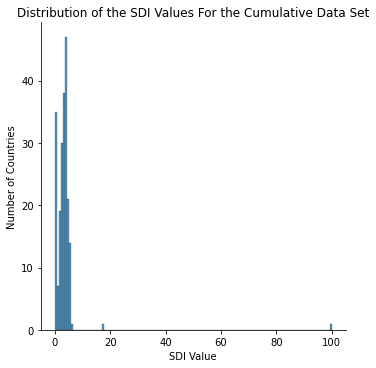

In [65]:
sns.displot(x='sdi', data=si_cum)
plt.title('Distribution of the SDI Values For the Cumulative Data Set')
plt.xlabel('SDI Value')
plt.ylabel('Number of Countries')

# Doing the Final merge of the SDI into the Cumulative and Time to event Data Sets

**Need** to create an SI for the cumulative case df The rationale behind this is that the cumulative df covers a wider date range

In [66]:
cum_df = cum_df.merge(si_cum,on='country',how='inner')
time_to_event_death = time_to_event_death.merge(si_death,on='country',how='inner')
time_to_event_case = time_to_event_case.merge(si_case,on='country')
cum_df.shape

(215, 43)

In [67]:
time_to_event_case.sort_values(by=['country','day'],inplace=True)
time_to_event_case['dup'] = time_to_event_case.duplicated('country',keep='last')
time_to_event_death.sort_values(by=['country','day'],inplace=True)
time_to_event_death['dup'] = time_to_event_death.duplicated('country',keep='last')

In [68]:
final_tte_case = time_to_event_case.loc[~time_to_event_case.dup].drop(columns=['dup','peak_death', 
                                                                               'death_muli_peak','school_close', 
                                                                               'case_max_rol_mean7','work_close', 
                                                                               'public_transpo', 'domestic_travel',
                                                                               'large_gather', 'public_events', 'stay_home'])
final_tte_death = time_to_event_death.loc[~time_to_event_death.dup].drop(columns=['dup','peak_case', 'case_reported', 
                                                                                  'death_max_rol_mean7', 'death_rol_mean7',
                                                                                  'school_close', 'work_close', 'public_transpo', 
                                                                                  'domestic_travel','large_gather', 'public_events', 'stay_home', ])

In [69]:
time_to_event_death.loc[~time_to_event_death.dup].groupby('country').day_num.max()

country
afghanistan           118
albania               250
algeria                49
andorra                34
angola                209
                     ... 
west bank and gaza    199
western sahara        174
yemen                  74
zambia                136
zimbabwe              159
Name: day_num, Length: 214, dtype: int64

In [70]:
time_to_event_death.loc[time_to_event_death.death_rol_mean7.round(3) == time_to_event_death['death_max_rol_mean7'].round(3)][['country','date','day','peak_death','death_max_rol_mean7','death_rol_mean7']]

,country,date,day,peak_death,death_max_rol_mean7,death_rol_mean7
117,afghanistan,2020-07-17,118 days 00:00:00,1,21.433333,21.433333
367,albania,2020-11-15,250 days 00:00:00,1,6.000000,6.000000
416,algeria,2020-04-29,49 days 00:00:00,1,13.633333,13.633333
450,andorra,2020-04-24,34 days 00:00:00,1,1.300000,1.300000
659,angola,2020-10-23,209 days 00:00:00,1,3.533333,3.533333
...,...,...,...,...,...,...
35054,western sahara,2020-06-23,29 days 00:00:00,0,0.033333,0.033333
35055,western sahara,2020-06-24,30 days 00:00:00,0,0.033333,0.033333
35273,yemen,2020-07-12,74 days 00:00:00,1,9.266667,9.266667
35409,zambia,2020-08-15,136 days 00:00:00,1,7.266667,7.266667


In [71]:
final_tte_death.peak_death.value_counts()

1    171
0     43
Name: peak_death, dtype: int64

In [72]:
final_tte_case[['country','peak_case','day','day_num']].head(10)

,country,peak_case,day,day_num
102,afghanistan,1,103 days 00:00:00,103
354,albania,1,252 days 00:00:00,252
619,algeria,1,265 days 00:00:00,265
878,andorra,0,259 days 00:00:00,259
1109,angola,1,231 days 00:00:00,231
1417,anguilla,0,308 days 00:00:00,308
1665,antigua and barbuda,0,248 days 00:00:00,248
1898,argentina,1,233 days 00:00:00,233
2145,armenia,1,247 days 00:00:00,247
2453,aruba,0,308 days 00:00:00,308


In [73]:
final_tte_case.columns

Index(['index', 'country', 'case_count', 'case_rol_mean7', 'date', 'gdp_rank',
       'gdp_in_mil_us', 'pop_2020', 'pop_den_per_sqkm',
       'un_population_division_median_age_2017',
       'ages_65_and_above_of_total_population',
       'prevalence_hivaids_sex_both_age_15_49_years_percent',
       'deaths_hivaids_sex_both_age', 'diabetes_prev_ages_20_to_79',
       'deaths_smoking_sex_both_age_age_standardized_rate',
       'cancer_prevalence', 'htn_prevalence', 'copd_dalys_per_100000',
       'obesity_ihme_2019', 'country_vulnerability', 'emergency_preparedness',
       'gov_efficiency', 'quarantine_efficiency', 'total_score',
       'mers_sars_quart', 'peak_case', 'case_peak_date', 'case_muli_peak',
       'day', 'day_num', 'SI_school_close', 'SI_work_close',
       'SI_public_transpo', 'SI_domestic_travel', 'SI_large_gather',
       'SI_public_events', 'SI_stay_home', 'SI_sum', 'constant', 'sdi'],
      dtype='object')

In [74]:
final_tte_death[['country','peak_death','day','day_num']].head(10)

,country,peak_death,day,day_num
117,afghanistan,1,118 days 00:00:00,118
367,albania,1,250 days 00:00:00,250
416,algeria,1,49 days 00:00:00,49
450,andorra,1,34 days 00:00:00,34
659,angola,1,209 days 00:00:00,209
967,anguilla,0,308 days 00:00:00,308
1190,antigua and barbuda,0,223 days 00:00:00,223
1417,argentina,1,227 days 00:00:00,227
1652,armenia,1,235 days 00:00:00,235
1960,aruba,0,308 days 00:00:00,308


In [75]:
final_tte_death.peak_death.value_counts()

1    171
0     43
Name: peak_death, dtype: int64

# Exporting the Final Data Sets

In [76]:
final_tte_case.date.max()

Timestamp('2020-11-15 00:00:00')

In [77]:
finaldf.date.max()

Timestamp('2020-11-15 00:00:00')

In [78]:
final_tte_case.to_excel(f'{out_data_path}\\COVID Time to Peak Case (Through {date}).xlsx',index=False)
final_tte_death.to_excel(f'{out_data_path}\\COVID Time to Peak Death (Through {date}) (ver2).xlsx',index=False)
cum_df.to_excel(f'{out_data_path}\\COVID Cumulative Incidence (Through {date}) (ver2).xlsx',index=False)
finaldf.to_excel(f'{out_data_path}\\COVID Final Daily Report (Through {date}) (ver2).xlsx',index=False)

In [79]:
final_tte_case.pop_den_per_sqkm.describe()

count      193.000000
mean       468.353904
std       2161.386691
min          0.136852
25%         36.253121
50%         87.176261
75%        214.242762
max      20546.765677
Name: pop_den_per_sqkm, dtype: float64

In [80]:
final_tte_case.pop_den_per_sqkm.describe()

count      193.000000
mean       468.353904
std       2161.386691
min          0.136852
25%         36.253121
50%         87.176261
75%        214.242762
max      20546.765677
Name: pop_den_per_sqkm, dtype: float64

In [81]:
(final_tte_case.pop_2020/10000).describe()

count       196.000000
mean       3906.685204
std       14717.429108
min           3.000000
25%         194.750000
50%         846.700000
75%        2787.725000
max      143932.400000
Name: pop_2020, dtype: float64

In [82]:
846.7 * 10000

8467000.0

## Exploring the Visual Relationship Between Case & Death Trends & Control Measures

<AxesSubplot:label='e980fb12-66aa-4de3-96a5-6ba0b0fdedfd', xlabel='day_num', ylabel='case_rol_mean7'>

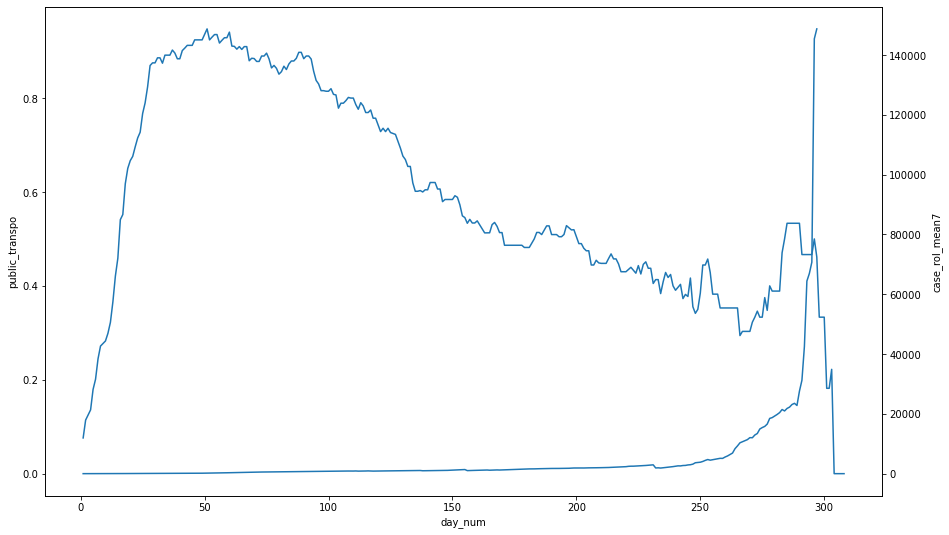

In [83]:
ax = sns.lineplot(x='day_num', y='public_transpo', data=time_to_event_case)
ax2 = ax.twinx()
sns.lineplot(x='day_num', y='case_rol_mean7', data=time_to_event_case, ax=ax2)

DONE


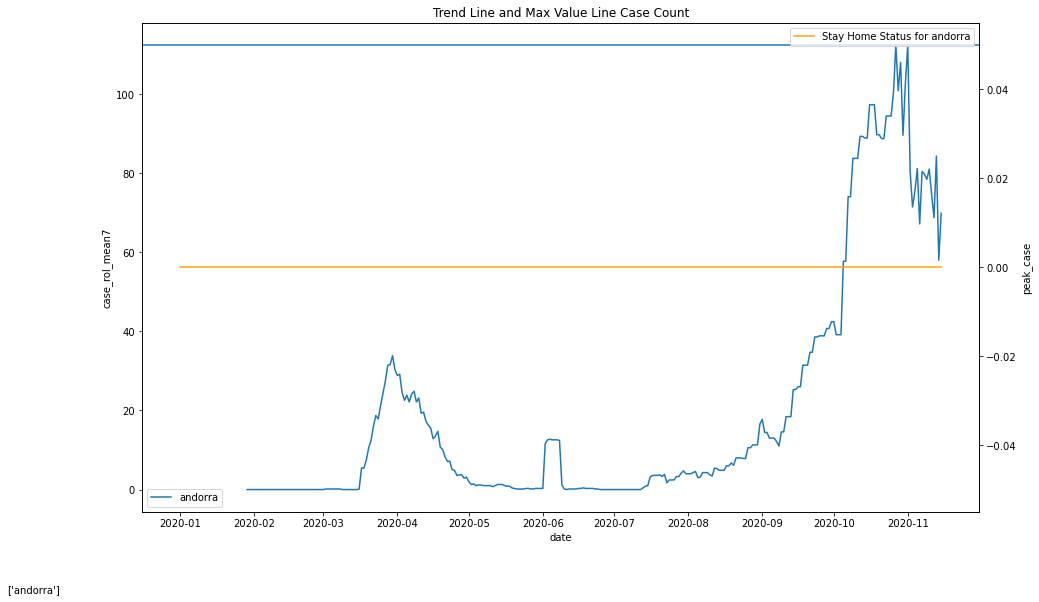

In [84]:
counter = 0 
country_list = []
for country in time_to_event.loc[time_to_event.pop_2020 < 1000000].country.unique():
    plt.title('Trend Line and Max Value Line Case Count')
    country_list.append(country)
    plt.figtext(0,0,country_list)
    ax = sns.lineplot(x='date' , y='case_rol_mean7', data=time_to_event.loc[time_to_event.country == country],label=country)
    plt.axhline(float(max_rol_mean_c.loc[max_rol_mean_c.country == country]['case_max_rol_mean7']))
    ax2 = ax.twinx()
    sns.lineplot(x='date' , y='peak_case', data=time_to_event.loc[time_to_event.country == country],label=f'Stay Home Status for {country}',ax=ax2,color='orange')
    
    counter += 1
    if counter == 1:
        print('DONE')
        break

DONE


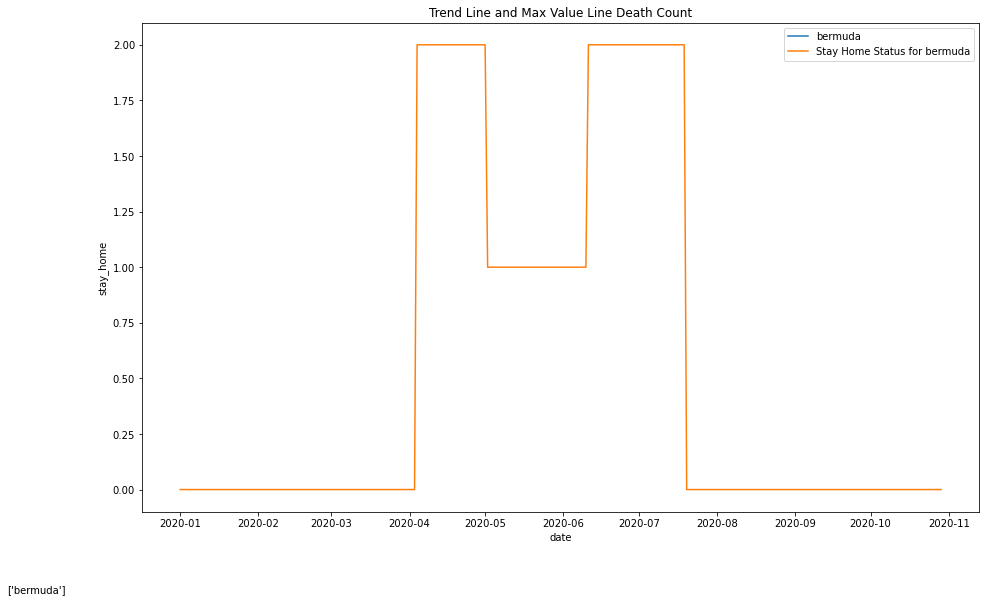

In [85]:
counter = 0 
country_list = []
for country in time_to_event.loc[time_to_event.pop_2020 < 70000].country.unique():
    plt.title('Trend Line and Max Value Line Death Count')
    country_list.append(country)
    plt.figtext(0,0,country_list)
    sns.lineplot(x='date' , y='death_rol_mean7', data=time_to_event.loc[time_to_event.country == country],label=country)
    sns.lineplot(x='date' , y='stay_home', data=time_to_event.loc[time_to_event.country == country],label=f'Stay Home Status for {country}')
    plt.axhline(float(max_rol_mean_d.loc[max_rol_mean_c.country == country]['death_max_rol_mean7']))
    counter += 1
    if counter == 1:
        print('DONE')
        break

# Checking to see How often case count values are greater than 10
doing this because the article 'Time Series Regression Model for Infectious Disease and Weather' indicated that it was important.

In [86]:
test = pd.DataFrame()

In [87]:
test[['country','date','case','death']] = long_df_newcontrol[['country','date','case_count','death_count']]

In [88]:
test['g10'] = 0

In [89]:
test.loc[test.case >=10 ,'g10']=1

In [90]:
test.g10.value_counts()/test.shape[0]

0    0.578365
1    0.421635
Name: g10, dtype: float64

## trying to work out country linking stuff

In [91]:
def similar_check(q,l):
    from fuzzywuzzy import fuzz,process
    from Levenshtein import distance,ratio
    import pandas as pd
    jhu = []
    similar = []
    query = []
    for countries in q:
        results = process.extractOne(countries,list(jhu_country)) 
        if results[1] < 100:
            jhu.append(results[0])
            similar.append(results[1])
            query.append(countries)
    output = pd.DataFrame({'query_country':query, 
                          'similarity':similar,
                           'jhu_country':jhu                       
                          })
    return output

In [92]:
# a list of the country names from each data set
jhu_country = long_case.country.unique()
ox_country = school.country.unique()
gdp_country = gdp.country
safe_country = safety.country
og_country = og_data.country

### Country Name Cleaner

## Oxford Data Country Names

In [93]:
ox_check = similar_check(ox_country ,jhu_country)
ox_check.sort_values(by='similarity', ascending=False)

,query_country,similarity,jhu_country
4,congo,90,congo (brazzaville)
20,turks and caicos islands,86,marshall islands
3,democratic republic of congo,86,congo (brazzaville)
6,czech republic,86,central african republic
12,kyrgyz republic,86,central african republic
19,slovak republic,86,central african republic
10,guam,77,nicaragua
9,greenland,75,grenada
21,turkmenistan,75,turkey
13,macao,73,monaco


## GDP Data Country Names

In [94]:
gdp_check = similar_check(gdp_country ,jhu_country)
gdp_check.sort_values(by='similarity', ascending=False)

,query_country,similarity,jhu_country
37,syrian arab republic,90,syria
6,democratic republic of congo,86,congo (brazzaville)
1,czech republic,86,central african republic
18,northern mariana islands,86,marshall islands
9,kyrgyz republic,86,central african republic
8,democratic republic of congo,86,congo (brazzaville)
19,turks and caicos islands,86,marshall islands
2,slovak republic,86,central african republic
33,north korea,82,south korea
11,guam,77,nicaragua


## Safety Data Country Names

In [95]:
safe_check = similar_check(safe_country ,jhu_country)
safe_check.sort_values(by='similarity', ascending=False).head(50)

,query_country,similarity,jhu_country
66,somaliland,90,mali
61,northern cyprus,90,cyprus
28,caribbean netherlands,90,netherlands
41,aland,90,new zealand
55,south georgia and the islands,90,georgia
25,united states virgin islands,90,united states
59,indian ocean territories,90,india
58,british indian ocean territory,90,india
4,republic of serbia,90,serbia
62,french southern and antarctic lands,86,antigua and barbuda


## OG Data Country Names

In [96]:
og_check = similar_check(og_country ,jhu_country)
og_check.sort_values(by='similarity', ascending=False)

,query_country,similarity,jhu_country
0,us,90,australia


# Code Grave Yard

### Importing the Oxford Control Measures Data Set (Ordinal)